# Image Captioning with Attention

Goal: Given an image, generate a caption aptly describing it.

**Attention based models** will allow us to see what parts of the image the model focuses on while generating the caption. When the RNN is generating a new word, the attention mechanism is focusing only on the relevant parts of the image (similar to what humans do)- so the decoder uses only specific parts of the image.

Reference for attention based image captioning: https://medium.com/swlh/image-captioning-using-attention-mechanism-f3d7fc96eb0e


## Framework

**Dataset:** MS COCO

**Architecture:** Inception V3 (https://cloud.google.com/tpu/docs/inception-v3-advanced)

**Model:** Encoder-Decoder


In [1]:
#importing libraries

import tensorflow as tf

#visualisation
import matplotlib.pyplot as plt

#scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Downloading and Preparing the MS COCO Dataset

In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 373s 0us/step


### Limit the size of the Training Set

To speed up processing, we use a subset of captions for training. Skip this step for improving the accuracy of captioning.

In [3]:
with open(annotation_file, 'r') as f:
  annotations= json.load(f)

#store caption and image names as vectors
all_captions=[]
all_img_name_vector=[]

for a in annotations['annotations']:
  caption = '<start>' + a['caption'] + '<end>'
  image_id = a['image_id']
  full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)

#Shuffle captions and image names together
train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state=1) #setting a random state

#Select first 30000 captions from the shuffled set ( more examples will give better accuracy but also more disk space)
num_examples= 30000
train_captions= train_captions[:num_examples]
img_name_vector= img_name_vector[:num_examples]


In [4]:
#Check

len(train_captions), len(all_captions)

(30000, 414113)

## Preprocessing using InceptionV3

InceptionV3 is pre-trained on Imagenet. We extract features from the last convolution layer.

We need to first convert the images into InceptionV3 format by resizing (to 299px x 299 px) and normalise the pixels to lie between -1 and 1 using preprocess_input (https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input)

In [5]:
def load_image(image_path):
  
  img= tf.io.read_file(image_path)
  img= tf.image.decode_jpeg(img, channels=3) #3 channels give an RGB image
  img= tf.image.resize(img, (299,299))
  img= tf.keras.applications.inception_v3.preprocess_input(img)

  return img, image_path


## Initialize InceptionV3, load pretrained weights

Create a model where the output layer is the last convolution layer in the InceptionV3 architecture (for attention). This is done by passing each image through the network and storing the resulting vector in a dictionary, which is then saved to disk. (Output layer size= 8 x 8 x 2048).

In [6]:
image_model= tf.keras.applications.InceptionV3(include_top= False, weights='imagenet')
#Include top will include the fully connected layer as the last layer of the network when True (https://keras.io/api/applications/inceptionv3/)

new_input= image_model.input
hidden_layer= image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


## Caching feature extracted to Disk


In [7]:
#to see progress bar
!pip install -q tqdm
from tqdm import tqdm

In [8]:
#unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train) #slices data on its first dimension (https://www.geeksforgeeks.org/tensorflow-tf-data-dataset-from_tensor_slices/)
image_dataset = image_dataset.map(load_image, num_parallel_calls= tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 1622/1622 [05:33<00:00,  4.86it/s]


## Preprocessing and Tokenising

In [9]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary, replacing every other word with UNK
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

#Creating word to index and index to word mappings. Padding all sequences to the length of the longest sequence

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

#Padding
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
#if maxLen is not specified, it automatically pads sequences to the length of the longest input sequence

#for attention weights
max_length = calc_max_length(train_seqs)

## Splitting Data into Train and Test Sets 



In [10]:
# 80-20 Split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [11]:
#Testing

len(img_name_train), len(img_name_val), len(cap_train), len(cap_val)

(24000, 6000, 24000, 6000)

## Create Training Dataset

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE =1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

features_shape = 2048
attention_features_shape = 64
#Vector extracted from InceptionV3 has shape (64,2048)

In [13]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [14]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
#map loads in parallel https://github.com/tensorflow/tensorflow/issues/33516


In [15]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Architecture:
1. Features are selected from the lower convolution layer of the InceptionV3 model. This is a (8, 8, 2048) vector.

2. We compress the vector to a size of (64, 2048).

3. This vector is passed through a fully connected CNN Encoder.

4. The RNN (GRU) predicts the next word.


In [16]:
#Reference for Attention Models: https://medium.com/swlh/image-captioning-using-attention-mechanism-f3d7fc96eb0e

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [17]:
class CNN_Encoder(tf.keras.Model):
    
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [18]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [19]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Create Checkpoints

In [21]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [22]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

1. Extract the features and pass them through the encoder.

2. The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.

3. The decoder returns the predictions and the decoder hidden state.

4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.

5. Use teacher forcing to decide the next input to the decoder. Teacher forcing is the technique where the target word is passed as the next input to the decoder.

6. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [23]:
loss_plot = []

In [24]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [25]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7971
Epoch 1 Batch 100 Loss 1.0276
Epoch 1 Batch 200 Loss 0.8953
Epoch 1 Batch 300 Loss 0.9452
Epoch 1 Loss 1.002264
Time taken for 1 epoch 389.7684009075165 sec

Epoch 2 Batch 0 Loss 0.8229
Epoch 2 Batch 100 Loss 0.8462
Epoch 2 Batch 200 Loss 0.7756
Epoch 2 Batch 300 Loss 0.8047
Epoch 2 Loss 0.789561
Time taken for 1 epoch 362.2775218486786 sec

Epoch 3 Batch 0 Loss 0.6697
Epoch 3 Batch 100 Loss 0.8072
Epoch 3 Batch 200 Loss 0.7206
Epoch 3 Batch 300 Loss 0.7285
Epoch 3 Loss 0.723157
Time taken for 1 epoch 362.60168266296387 sec

Epoch 4 Batch 0 Loss 0.7033
Epoch 4 Batch 100 Loss 0.8065
Epoch 4 Batch 200 Loss 0.7258
Epoch 4 Batch 300 Loss 0.6594
Epoch 4 Loss 0.680032
Time taken for 1 epoch 364.2244162559509 sec

Epoch 5 Batch 0 Loss 0.6610
Epoch 5 Batch 100 Loss 0.6994
Epoch 5 Batch 200 Loss 0.6745
Epoch 5 Batch 300 Loss 0.6480
Epoch 5 Loss 0.644965
Time taken for 1 epoch 353.2017273902893 sec

Epoch 6 Batch 0 Loss 0.6152
Epoch 6 Batch 100 Loss 0.6355
Epoch 6 Bat

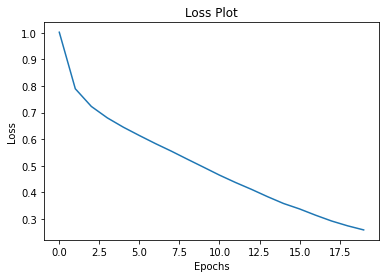

In [26]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Captioning

1. The evaluate function is similar to the training loop, but there is no teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.

2. Predictions stop when when the model predicts the end token.

3. Attention weights are stored for every time step.

In [27]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [28]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start>two giraffes are standing next to a tree trying to get something to eat <end>
Prediction Caption: elephant next to a fence <end>


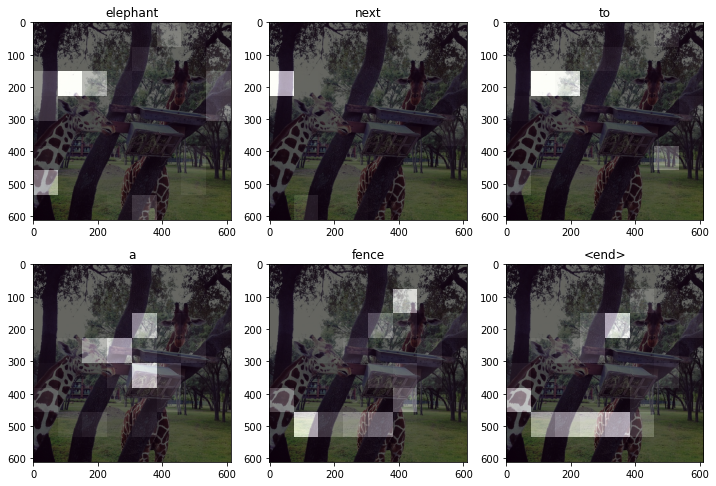

In [29]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Testing

65536/64400 [==============================] - 0s 2us/step
Prediction Caption: young girl lays down a wave <end>


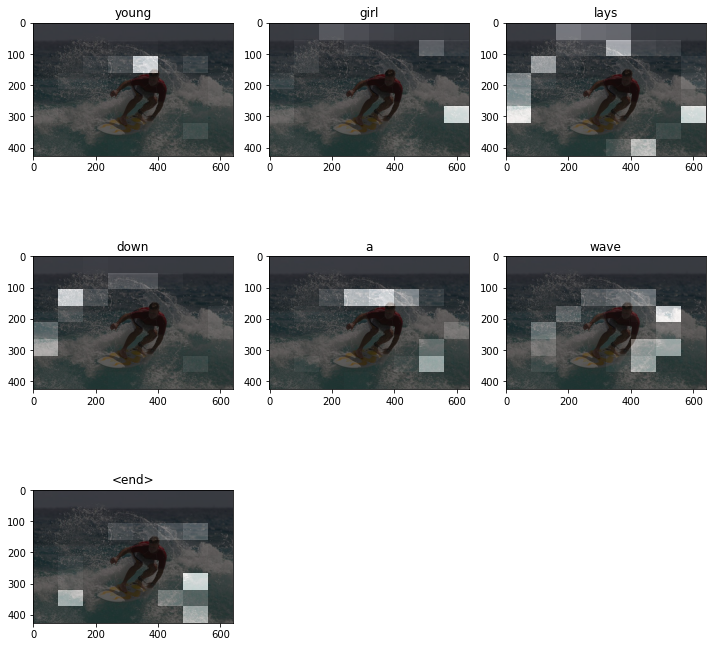

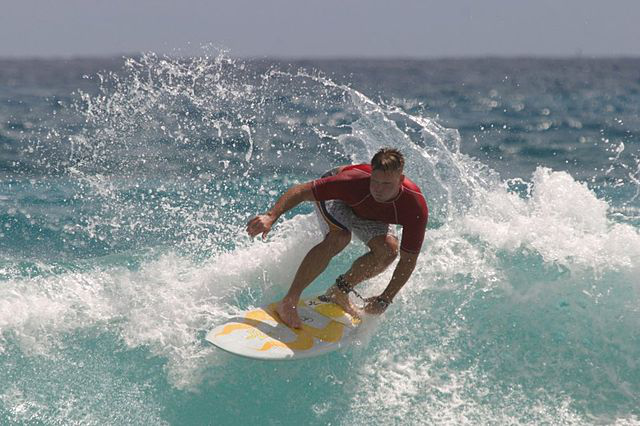

In [30]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)